In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set global font properties for better readability
sns.set_style("ticks")

plt.rcParams["font.family"] = "sans-serif"  # Use a sans-serif font
plt.rcParams["font.sans-serif"] = [
    "DejaVu Sans",
    "Liberation Sans",
    "Helvetica",
    "Arial",
]
plt.rcParams["font.size"] = 12  # Default font size
plt.rcParams["axes.facecolor"] = "#e7e7e7"
plt.rcParams["grid.color"] = "white"
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 0.5
# Make
#    ax.yaxis.set_label_coords(0, 1.05, transform=ax.transAxes)
plt.rcParams["axes.labelpad"] = 10  # Padding between axes label and ticks

plt.rcParams.update(
    {
        "text.usetex": False,
        "text.latex.preamble": r"\usepackage{amsmath}",
    }
)
# Larger font sizes for specific elements
TITLE_FONT_SIZE = 14
plt.rcParams["axes.titlesize"] = TITLE_FONT_SIZE
plt.rcParams["figure.titlesize"] = TITLE_FONT_SIZE
LABEL_FONT_SIZE = 13
plt.rcParams["axes.labelsize"] = LABEL_FONT_SIZE
TICK_LABEL_SIZE = 12
plt.rcParams["xtick.labelsize"] = TICK_LABEL_SIZE
LEGEND_FONT_SIZE = 12
plt.rcParams["legend.fontsize"] = LEGEND_FONT_SIZE

from pathlib import Path

directory1 = Path("csvs/plottable")
# directory2 = Path(
#     "csvs/auto_vectorization_ON"
# )
directory3 = Path("csvs/neon")
# # files = [
#     "measurements_bits_block2_4_8_16.csv",
#     "measurements_sp_load_no_vec.csv",
#     "measurements.csv",
# ]
files = list(directory1.glob("m_*.csv"))
print("Files found:", len(files))
# files += list(directory2.glob("m_*.csv"))
# print("Files added:", len(files))
files += list(directory3.glob("m_*.csv"))
print("Files added:", len(files))

df = None
dfs = []


def unify_compiler_flags(compiler_flags: str) -> str:
    """Unify the compiler flags."""
    if "-march=native" in compiler_flags:
        compiler_flags = compiler_flags.replace(" -mbmi2 ", " ")
        compiler_flags = compiler_flags.replace(" -mavx2 ", " ")
    compiler_flags = compiler_flags.replace(" -g ", " ")
    compiler_flags = compiler_flags.replace(" -g3 ", " ")
    while "  " in compiler_flags:
        compiler_flags = compiler_flags.replace("  ", " ")
    return compiler_flags.strip()


def unify_imlementation_name(implementation: str) -> str:
    """Unify the implementation name."""
    implementation = implementation.replace("block", "inter")
    implementation = implementation.replace("unroll", "intra")
    while "  " in implementation:
        implementation = implementation.replace("  ", " ")
    implementation = implementation.strip()
    return implementation


for file in files:
    print(file)
    df0 = pd.read_csv(file)
    df0["implementation"] = df0["implementation"].apply(unify_imlementation_name)
    df0["compiler_flags"] = df0["compiler_flags"].apply(unify_compiler_flags)
    dfs.append(df0)


def project_compiler(compiler_version: str) -> str:
    """Project the compiler version to a more general form."""
    if "gcc" in compiler_version:
        return "gcc"
    elif "clang" in compiler_version:
        return "clang"
    elif "Apple" in compiler_version:
        return "Apple Clang"
    else:
        return compiler_version


df = pd.concat(dfs, ignore_index=True)
df = (
    df.groupby(
        [
            "compiler_version",
            "compiler_flags",
            "cpu_model",
            "implementation",
            "bits",
        ]
    )
    .median()
    .reset_index()
)
# file = "measurements_bits_block2_4_8_16.csv"
# file="measurements_sp_load_no_vec.csv"
# file="measurements.csv"
# df = pd.read_csv(file)
# df = (
#     df.groupby(
#         ["compiler_version", "compiler_flags", "cpu_model", "implementation", "bits"]
#     )
#     .median()
#     .reset_index()
# )


# print(df["implementation"].unique())
# print(df["compiler_version"].unique())
# print(df["compiler_flags"].unique())
df["compiler_short"] = df["compiler_version"].apply(project_compiler)
df["ops"] = df["bits"] * 3 ** df["bits"]
df["memory"] = (3 ** df["bits"]) / 8
df["operational_intensity"] = df["ops"] / df["memory"]
df["performance"] = df["ops"] / df["cycles"]
df["cache_miss_ratio"] = df["l1d_cache_misses"] / df["l1d_cache_accesses"]
df["cache_misses_per_implicant"] = df["l1d_cache_misses"] / 3 ** df["bits"]
# df['hellman'] = df["implementation"].str.contains("hellman", na=False)
df["no_vec"] = ~(
    df["compiler_flags"].str.contains("no-vectorize", na=False)
    | df["compiler_flags"].str.contains("no-tree-vectorize", na=False)
)
df["function"] = (
    df["implementation"] + ", " + df["compiler_version"] + ", " + df["compiler_flags"]
)
# print(df)


# Filter out compiler_version if they don't contain 'gcc'
df_neon = df[df["compiler_version"].str.contains("Apple", na=False)]
# df_all_compilers = df.copy()
# df = df[df["compiler_version"].str.contains("gcc", na=True)]

colors = [
    "#b9002e",
    "#005cb9",
    "#5cb900",
    "#b95c00",
    "#820082",
    "#00b9b9",
    "#b9b900",
    "#b90082",
    "#d4003f",
    "#003fd4",
    "#00d435",
    "#d46f00",
    "#6f00d4",
    "#00d4d4",
    "#d4d400",
    "#8200b9",
    "#0082b9",
    "#00b982",
    "#5c0082",
    "#82005c",
]
COLOR_MAP = {
    (None, "baseline"): "#b9002e",
    (None, "bits"): "#005cb9",
    (None, "hellman"): "#5cb900",
    (None, "pext"): "#b95c00",
    (None, "pext_sp"): "#820082",
    (None, "pext_sp_inter2"): "#00b9b9",
    (None, "pext_sp_intra"): "#b9b900",
    (None, "pext_sp_load_inter2 (auto-vec)"): "#b90082",
    (None, "pext_sp_load_inter2"): "#d4003f",
    (None, "avx2_sp_load_inter2 (auto-vec)"): "#d4003f",
    (None, "avx512_sp_load_inter2 (auto-vec)"): "#00d435",
    (None, "bits (auto-vec)"): "#d46f00",
    (None, "pext (auto-vec)"): "#6f00d4",
    (None, "pext_sp (auto-vec)"): "#00d4d4",
    (None, "pext_sp_intra (auto-vec)"): "#d4d400",
    (None, "baseline (auto-vec)"): "#8200b9",
    (None, "bits_sp_load_inter2 (auto-vec)"): "#0082b9",
    (None, "neon_sp_load_inter4 (auto-vec)"): "#00b982",
    (None, "pext_sp_inter2 (auto-vec)"): "#5c0082",
    # (None, "avx2_sp_load_inter2"): "#82005c",
    # (None, "avx512_sp_load_inter2"): "#b9002e",
}


def lighten_color(color, factor=0.2):
    """Lighten a color by a given factor."""
    import matplotlib.colors as mcolors

    c = mcolors.to_rgb(color)
    return mcolors.to_hex([min(1, x + factor) for x in c])


def nice_function_name(function, compiler_flags):
    unroll = "unroll" in function
    block = "block" in function
    if unroll and block:
        raise ValueError("Function name cannot contain both 'unroll' and 'block'.")
    function = function.replace("unroll", "intra").replace("block", "inter")
    # autovec = False
    # if "pext" in function or "bits" in function:
    #     autovec = True
    #     if any(
    #         x in compiler_flags
    #         for x in ["no-vectorize", "no-tree-vectorize", "no-slp-vectorize"]
    #     ):
    #         autovec = False
    # if autovec:
    #     return function + " (auto-vec)"
    return function + f"\n({compiler_flags})"


def get_color_by_function_and_flags(function, flags):
    """Get a color based on the function and CPU model."""
    no_vectorize = "no-tree-vectorize" in flags
    flags = None
    if not no_vectorize and "hellman" not in function:
        function += " (auto-vec)"
    if (flags, function) not in COLOR_MAP:
        v = COLOR_MAP[flags, function] = colors.pop(0)  # Pop a color from the list
        colors.append(v)
        print("Color", function, flags, ":", COLOR_MAP[(flags, function)])
    # if not no_vectorize and 'hellman' not in function:
    #     return lighten_color(COLOR_MAP[flags, function], factor=0.2)
    return COLOR_MAP[flags, function]


# Generate an unique color for each function x cpu_model combination
unique_functions = df["function"].unique()
unique_cpu_models = df["cpu_model"].unique()
# colors = sns.color_palette("pastel6", len(unique_functions) * len(unique_cpu_models))
# color_map = {}
# print(unique_functions)
# for i, function in enumerate(unique_functions):
#     for j, cpu_model in enumerate(unique_cpu_models):
#         color_map[(cpu_model, function)] = colors[
#             (i * len(unique_cpu_models) + j) % len(colors)
#         ]
df.to_csv("df.csv", index=False)

Files found: 11
Files added: 15
/home/aljaz/ETH/FS2025-Advanced-Systems-Lab/team58/csvs/plottable/m_avx512_sp_load_block2_clang.csv
/home/aljaz/ETH/FS2025-Advanced-Systems-Lab/team58/csvs/plottable/m_pext_sp_inter2_gcc.csv
/home/aljaz/ETH/FS2025-Advanced-Systems-Lab/team58/csvs/plottable/m_hellman_gcc.csv
/home/aljaz/ETH/FS2025-Advanced-Systems-Lab/team58/csvs/plottable/m_pext_sp_gcc.csv
/home/aljaz/ETH/FS2025-Advanced-Systems-Lab/team58/csvs/plottable/m_pext_sp_intra_gcc.csv
/home/aljaz/ETH/FS2025-Advanced-Systems-Lab/team58/csvs/plottable/m_pext_sp_load_inter2_gcc.csv
/home/aljaz/ETH/FS2025-Advanced-Systems-Lab/team58/csvs/plottable/m_avx2_sp_load_inter2_clang.csv
/home/aljaz/ETH/FS2025-Advanced-Systems-Lab/team58/csvs/plottable/m_pext_gcc.csv
/home/aljaz/ETH/FS2025-Advanced-Systems-Lab/team58/csvs/plottable/m_bits_gcc.csv
/home/aljaz/ETH/FS2025-Advanced-Systems-Lab/team58/csvs/plottable/m_baseline_gcc.csv
/home/aljaz/ETH/FS2025-Advanced-Systems-Lab/team58/csvs/plottable/m_pext_sp_lo

In [120]:
import networkx as nx
from matplotlib.lines import Line2D
from typing import List, Tuple


def plot_networkx_spring_labels(
    lines: List[Line2D], k: float = 0.6, *, indicies: List[int]
):
    """
    Plots lines and dynamically labels them on the chart using networkx's spring layout.

    Args:
        ax (matplotlib.axes.Axes): The axes object to plot on.
        data_lines (list of tuples): Each tuple should be (x_data, y_data).
        labels (list of str): Corresponding labels for each line.
    """
    G = nx.Graph()
    initial_pos = {}  # Store initial positions for fixed anchor points
    num_lines = len(lines)
    for i, line in enumerate(lines):
        x, y = line.get_xdata(), line.get_ydata()
        for j in indicies:
            anchor_x = x[j]
            anchor_y = y[j]
            anchor_node_name = f"anchor_{i}_{j}"
            label_node_name = f"label_{i}_{j}"

            # Add nodes to the networkx graph
            G.add_node(anchor_node_name)
            G.add_node(label_node_name)
            G.add_edge(label_node_name, anchor_node_name)

            # # Connect last 10 points of the line to the label node
            # last = anchor_node_name
            # AROUND_N = 1
            # for j, (xi, yi) in enumerate(
            #     zip(x[j - AROUND_N : j + AROUND_N], y[j - AROUND_N : j + AROUND_N])
            # ):
            #     name = f"point_{i}_{j}"
            #     G.add_node(name)
            #     G.add_edge(name, last)
            #     initial_pos[name] = np.array([xi, yi])
            #     last = name

            initial_pos[anchor_node_name] = np.array([anchor_x, anchor_y])

    # --- Run networkx spring layout ---
    # `pos` will be a dictionary mapping node names to (x,y) coordinates
    # We pass `initial_pos` to `pos` to tell spring_layout where our anchor points are fixed.
    # iterations: more iterations for more stability
    # k: optimal distance between nodes. Adjust this to control how close labels are.
    #    Smaller k means labels will be closer, larger k means they'll spread out.
    pos = nx.spring_layout(
        G,
        pos=initial_pos,
        fixed=list(initial_pos.keys()),
        iterations=200,
        k=k,
    )  # Adjust k as needed

    ret = {}
    for i in range(num_lines):
        for j in indicies:
            label_node_name = f"label_{i}_{j}"
            text_x, text_y = pos[label_node_name]
            if i not in ret:
                ret[i] = {}
            ret[i][j] = (text_x, text_y)
    return ret

['bits' 'bits_sp_load_inter2' 'hellman' 'neon_sp_load_inter4'
 'avx2_sp_load_inter2' 'avx512_sp_load_inter2' 'pext_sp_load_inter2'
 'baseline' 'pext' 'pext_sp' 'pext_sp_inter2' 'pext_sp_intra']
Wrote reportfigs/performance_hellman_baseline_bits_pext_pext_sp.pdf
Wrote reportfigs/performance_hellman.pdf
Wrote reportfigs/performance_hellman_pext_sp_load_inter2_pext_sp_pext_sp_inter2_pext_sp_intra.pdf
            implementation                           compiler_version  \
88     avx2_sp_load_inter2     Ubuntu clang version 18.1.3 (1ubuntu1)   
111  avx512_sp_load_inter2     Ubuntu clang version 18.1.3 (1ubuntu1)   
134                hellman  gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0   
157    pext_sp_load_inter2  gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0   
311    pext_sp_load_inter2  gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0   

                               compiler_flags  
88           -march=native -O3 -fno-vectorize  
111          -march=native -O3 -fno-vectorize  
134             

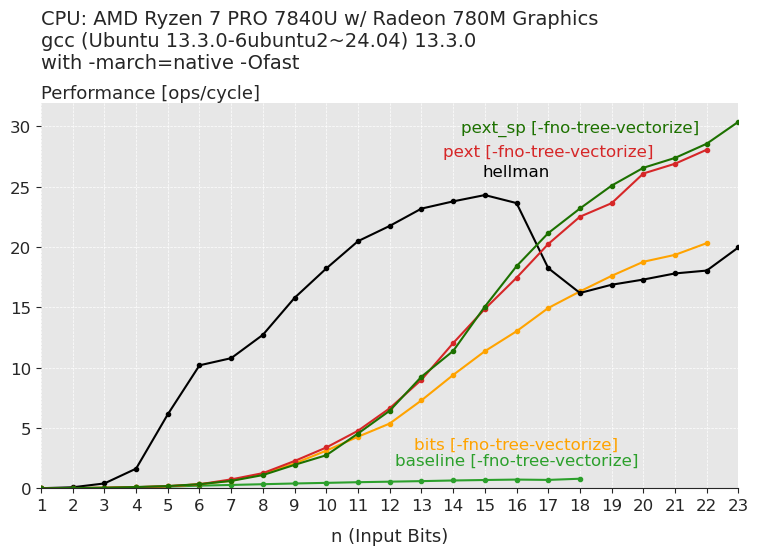

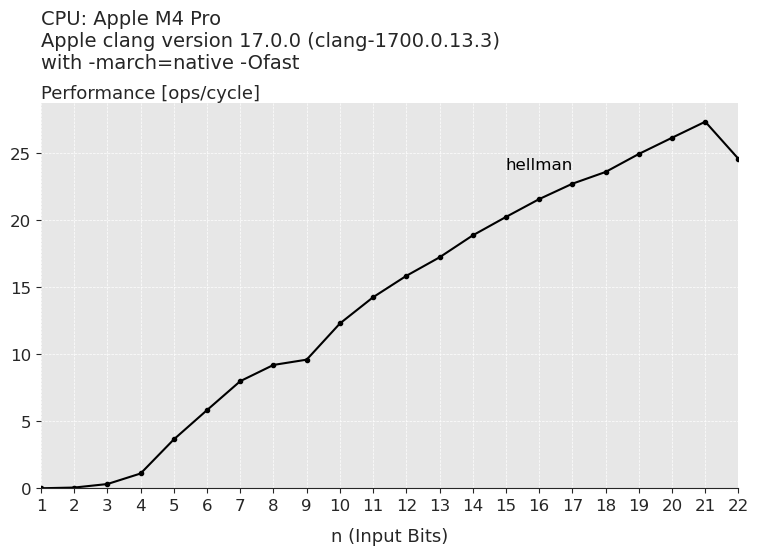

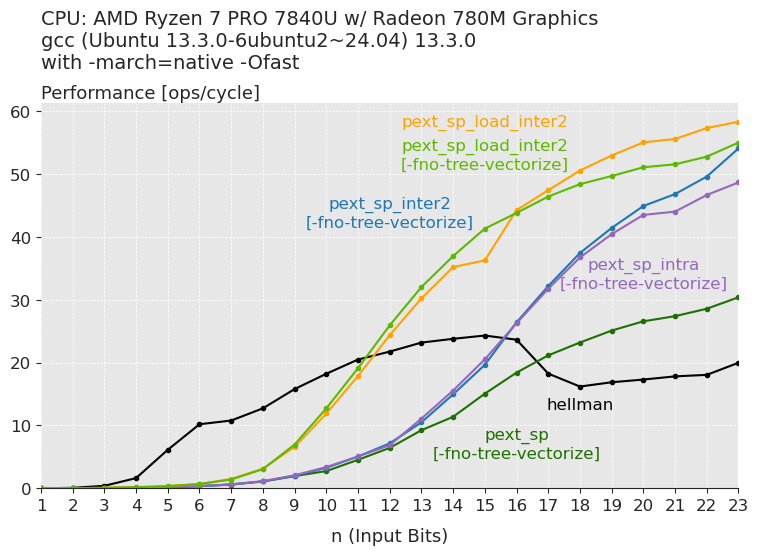

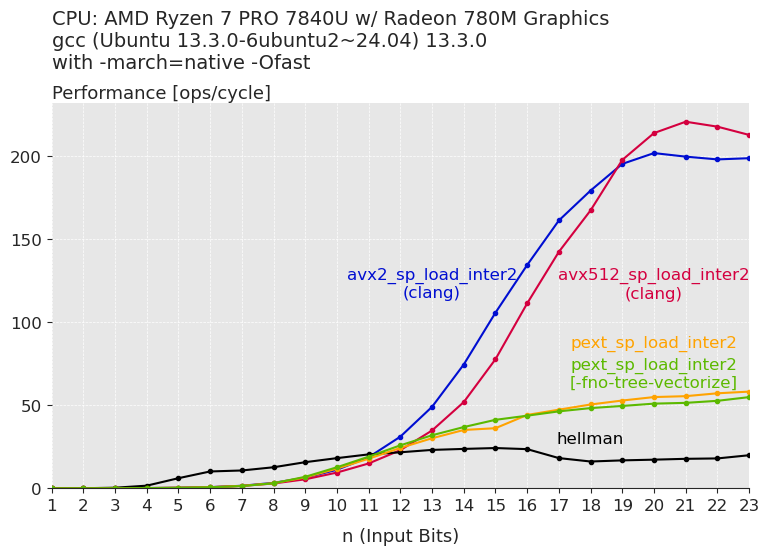

In [121]:
from typing import Dict


def performance_plot(
    df: pd.DataFrame, title: str, annotations: Dict[str, Tuple[int, int, str]] = None
):
    if annotations is None:
        annotations = {}
    num_annotated = 0
    num_lines = 0
    for (cpu_model,), df_grouped in df.groupby(
        [
            "cpu_model",
        ]
    ):
        plt.figure(figsize=(9, 5))
        ax = plt.gca()
        lines: List[Tuple[str, Line2D]] = []
        for (
            implementation,
            compiler_flags,
            compiler_version,
        ), group in df_grouped.groupby(
            [
                "implementation",
                "compiler_flags",
                "compiler_version",
            ]
        ):
            color = get_color_by_function_and_flags(implementation, compiler_flags)
            label = nice_function_name(implementation, compiler_flags)
            group.plot.line(
                x="bits",
                y="performance",
                label=label,
                legend=None,
                marker="o",
                markersize=3,
                linestyle="-",
                color=color,
                ax=ax,
            )
            compiler = None
            if "gcc" in compiler_version:
                compiler = "gcc"
            elif "clang" in compiler_version:
                compiler = "clang"
            elif "Apple" in compiler_version:
                compiler = "Apple"
            if compiler is None:
                raise ValueError(f"Unknown compiler version: {compiler_version}")
            if implementation in annotations:
                x, y_delta, txt = annotations[implementation]
                y = group[group["bits"] == x]["performance"].values[0]
                if "no-tree-vectorize" not in compiler_flags:
                    y_delta = y_delta + 9
                ax.annotate(
                    txt.format(
                        implementation=implementation,
                        compiler_flags=compiler_flags,
                        vectorize=(
                            "[-fno-tree-vectorize]"
                            if "no-tree-vectorize" in compiler_flags
                            else ""
                        ),
                        compiler=compiler,
                    ),
                    xy=(x, y),
                    xytext=(x, y + y_delta),
                    ha="center",
                    va="bottom",
                    # arrowprops=dict(arrowstyle="->", color=color),
                    # fontsize=10,
                    color=color,
                )
                num_annotated += 1
            num_lines += 1
            line = ax.lines[-1]  # Get the last line added to the axes
            lines.append((implementation, line))

        # Keep only bottom spine
        for spine in ("left", "top", "right"):
            ax.spines[spine].set_visible(False)
        if num_lines > num_annotated:
            plt.legend(
                loc="upper left",
                # bbox_to_anchor=(1, 1),
            )
        plt.xlabel("n (Input Bits)")

        plt.ylabel(
            r"Performance [ops/cycle]",
            rotation=0,
            verticalalignment="top",
            horizontalalignment="left",
        )
        ax.yaxis.set_label_coords(0, 1.05, transform=ax.transAxes)
        nice_title = "Performance Plot for Different Implementations"
        plt.title(
            # r"$\mathbf{"
            # + nice_title.replace(" ", r" \ ")
            # + "}$"+ "\n"
            title.format(
                cpu_model=cpu_model,
                compiler_version=compiler_version,
            ),
            loc="left",
            y=1.07,
            # fontdict={"weight": "bold"},
        )
        plt.grid(True)
        plt.autoscale(enable=True, axis="y", tight=False)
        plt.ylim(bottom=0)
        # plt.xlim(left=min(df_grouped["bits"]), right=max(df_grouped["bits"]))
        plt.margins(x=0)
        plt.xticks(df_grouped["bits"].unique())
        # plt.savefig("performance.png", dpi=300, bbox_inches="tight")
        # plt.show()
        Path("reportfigs").mkdir(parents=True, exist_ok=True)
        name = "_".join(df_grouped["implementation"].unique())
        for ext in [
            ".png",
            ".pdf",
        ]:
            plt.savefig(
                f"reportfigs/performance_{name}{ext}",
                dpi=300,
                bbox_inches="tight",
            )
        print("Wrote", f"reportfigs/performance_{name}.pdf")


print(df["implementation"].unique())
# Select 'baseline', 'bits', 'pext' 'hellman' from df for implementations
df_nonvec = (
    df["compiler_flags"].str.contains("no-vectorize", na=False)
    | df["compiler_flags"].str.contains("no-tree-vectorize", na=False)
    | df["compiler_flags"].str.contains("no-slp-vectorize", na=False)
)
df_vec = ~df_nonvec | (df["implementation"] == "hellman")
df_nonvec = df_nonvec | (df["implementation"] == "hellman")  # Always include hellman

df_g0 = df[
    df["implementation"].isin(
        [
            "baseline",
            "bits",
            "pext",
            "pext_sp",
            "hellman",
            "bits, pext",
        ]
    )
    & df_nonvec
]
"""
hellman, gcc
pext, gcc, no-tree-vectorize
pext_sp, gcc, no-tree-vectorize
bits, gcc, no-tree-vectorize
baseline, gcc, no-tree-vectorize
"""

# versions = (
#     (df['implementation'] == 'hellman') |
#     ((df['implementation'] == 'pext') & df_nonvec) |
#     ((df['implementation'] == 'bits') & df_nonvec) |
#     ((df['implementation'] == 'baseline') & df_nonvec)
# )

# df_g0 = df_g0[versions]

# pext_sp vs pext_sp_intra vs pext_sp_interX vs pext_sp_loadX
df_g1 = df[
    df["implementation"].isin(
        [
            "pext_sp",
            "pext_sp_intra",
            "hellman",
            "pext_sp_inter2",
            "pext_sp_load_inter2",
        ]
    )
    # & (df["implementation"].str.contains("pext_sp_load_inter2", na=False))
    & (
        df_nonvec
        | df["implementation"].str.contains("pext_sp_inter2", na=False)
        | df["implementation"].str.contains("pext_sp_load_inter2", na=False)
    )
]

df_g1 = df_g1[
    # Deselect implementation pext_sp_load_inter2 with no vectorization
    ~(
        (df_g1["implementation"] == "pext_sp_load_inter2")
        & df_g1["compiler_flags"].str.contains("no-tree-vectorize", na=False)
    )
]

# Select explicitly versions:
"""
hellman, gcc
# pext_sp_load_inter2, gcc
pext_sp_load_inter2, gcc, no-tree-vectorize
pext_sp_load_inter2, gcc
pext_sp_inter2, gcc, no-tree-vectorize
pext_sp_intra, gcc, no-tree-vectorize
pext_sp, gcc, no-tree-vectorize
"""
masks_df_g1 = (
    (
        (df["implementation"] == "hellman")
        & df["compiler_version"].str.contains("gcc", na=False)
    )
    | (
        (df["implementation"] == "pext_sp_load_inter2")
        & df["compiler_version"].str.contains("gcc", na=False)
    )
    | (
        (df["implementation"] == "pext_sp_inter2")
        & df["compiler_version"].str.contains("gcc", na=False)
        & df["compiler_flags"].str.contains("no-tree-vectorize", na=False)
    )
    | (
        (df["implementation"] == "pext_sp_intra")
        & df["compiler_flags"].str.contains("no-tree-vectorize", na=False)
    )
    | (
        (df["implementation"] == "pext_sp")
        & df["compiler_flags"].str.contains("no-tree-vectorize", na=False)
    )
)
df_g1 = df[masks_df_g1]

# df_g2 = df[
#     df["implementation"].isin(
#         [
#             "pext_sp_load_inter2",
#             "hellman",
#             "avx2_sp_load_intra",
#             # "avx2_sp_load_inter2", ##
#             "avx2_sp_load_inter4",
#             "avx512_sp_load_intra",
#             "avx512_sp_load_inter2",
#             # "avx512_sp_load_inter4", ##
#         ]
#     )
#     & (
#         # Take everything nonvectorized, except
#         df_nonvec| df["implementation"].str.contains("pext_sp_load_inter2", na=False)
#     )
# ]
# df_g2 = df_g2[
#     # Deselect implementation pext_sp_load_inter2 with no vectorization
#     ~(
#         (df_g2["implementation"] == "pext_sp_load_inter2")
#         & df_g2["compiler_flags"].str.contains("no-tree-vectorize", na=False)
#     )
# ]
"""
avx512_sp_load_inter2, clang, no-tree-vectorize
avx2_sp_load_inter2, clang, no-tree-vectorize
pext_sp_load_inter2, gcc
pext_sp_load_inter2, gcc, no-tree-vectorize
hellman, gcc
"""

df_g2_base = df
df_g2 = df_g2_base[
    (
        (df_g2_base["implementation"] == "hellman")
        & df_g2_base["compiler_version"].str.contains("gcc", na=False)
    )
    | (
        (df_g2_base["implementation"] == "pext_sp_load_inter2")
        & df_g2_base["compiler_version"].str.contains("gcc", na=False)
    )
    | (
        (df_g2_base["implementation"] == "avx2_sp_load_inter2")
        & df_g2_base["compiler_version"].str.contains("clang", na=False)
        & df_g2_base["compiler_flags"].str.contains(
            "no-vectorize", na=False
        )
    )
    | (
        (df_g2_base["implementation"] == "avx512_sp_load_inter2")
        & df_g2_base["compiler_version"].str.contains("clang", na=False)
        & df_g2_base["compiler_flags"].str.contains(
            "no-vectorize", na=False
        )
    )
]


COLOR_MAP = {
    (None, "baseline"): "#2ca02c",
    (None, "hellman"): "#000000",
    (None, "bits"): "#ffa300",

    (None, "pext"): "#d62728",
    (None, "pext_sp"): "#1d7100",

    (None, "pext_sp_inter2"): "#1f77b4",
    (None, "pext_sp_intra"): "#9467bd",

    (None, "pext_sp_load_inter2 (auto-vec)"): "#ffa300",
    (None, "pext_sp_load_inter2"): "#5cb900",

    (None, "avx2_sp_load_inter2 (auto-vec)"): "#000ed1",
    (None, "avx512_sp_load_inter2 (auto-vec)"): "#d4003f",
    (None, "avx2_sp_load_inter2"): "#000ed1",
    (None, "avx512_sp_load_inter2"): "#d4003f",
}
# COLOR_MAP = {
#     (None, "baseline"): "#4daf4a",
#     (None, "hellman"): "#000000",
#     (None, "bits"): "#1f77b4",

#     (None, "pext"): "#756bb1",
#     (None, "pext_sp"): "#31a354",

#     (None, "pext_sp_inter2"): "#66c2a5",
#     (None, "pext_sp_intra"): "#fc8d59",

#     (None, "pext_sp_load_inter2 (auto-vec)"): "#2ca02c",
#     (None, "pext_sp_load_inter2"): "#d62728",

#     (None, "avx2_sp_load_inter2 (auto-vec)"): "#1f77b4",
#     (None, "avx512_sp_load_inter2 (auto-vec)"): "#9467bd",
# }

    # (None, "bits (auto-vec)"): "#d46f00",
    # (None, "pext (auto-vec)"): "#6f00d4",
    # (None, "pext_sp (auto-vec)"): "#00d4d4",
    # (None, "pext_sp_intra (auto-vec)"): "#d4d400",
    # (None, "baseline (auto-vec)"): "#8200b9",
    # (None, "bits_sp_load_inter2 (auto-vec)"): "#0082b9",
    # (None, "neon_sp_load_inter4 (auto-vec)"): "#00b982",
    # (None, "pext_sp_inter2 (auto-vec)"): "#5c0082",
    # (None, "avx2_sp_load_inter2"): "#82005c",
    # (None, "avx512_sp_load_inter2"): "#b9002e",
performance_plot(
    df_g0,
    "CPU: {cpu_model}\n{compiler_version}\nwith -march=native -Ofast",
    {
        "baseline": (16, +1, "{implementation} [-fno-tree-vectorize]"),
        "hellman": (16, +1 - 3-5, "{implementation}"),
        "bits": (16, -10, "{implementation} [-fno-tree-vectorize]"),
        "pext": (17, +4+3, "{implementation} [-fno-tree-vectorize]"),
        "pext_sp": (18, +5+1, "{implementation} [-fno-tree-vectorize]"),
    },
)
performance_plot(
    df_g1,
    "CPU: {cpu_model}\n{compiler_version}\nwith -march=native -Ofast",
    {
        "hellman": (18, -3 - 10, "{implementation}"),
        "pext_sp": (16, -20 + 6, "{implementation}\n{vectorize}"),
        "pext_sp_intra": (20, -10 - 2, "{implementation}\n{vectorize}"),
        "pext_sp_inter2": (12, +29 + 3 + 2, "{implementation}\n{vectorize}"),
        "pext_sp_load_inter2": (15, +3 + 6, "{implementation}\n{vectorize}"),
    },
)
print(df_g2[["implementation", "compiler_version", "compiler_flags"]].drop_duplicates())
performance_plot(
    df_g2,
    "CPU: {cpu_model}\n{compiler_version}\nwith -march=native -Ofast",
    {
        "hellman": (18, +8-8, "{implementation}"),
        "pext_sp_load_inter2": (19+1, +8, "{implementation}\n{vectorize}"),
        "avx2_sp_load_inter2": (13, 55, "{implementation}\n({compiler})"),
        "avx512_sp_load_inter2": (19+1, -110, "{implementation}\n({compiler})"),
    },
)

['bits' 'bits_sp_load_inter2' 'hellman' 'neon_sp_load_inter4'
 'avx2_sp_load_inter2' 'avx512_sp_load_inter2' 'pext_sp_load_inter2'
 'baseline' 'pext' 'pext_sp' 'pext_sp_inter2' 'pext_sp_intra']
Max speedup at 20 of avx2_sp_load_inter2  clang is 11.672789600101375 faster than hellman
    Speedup at 17 of avx2_sp_load_inter2  clang is 8.843744656286269 faster than hellman
Max speedup at 21 of avx512_sp_load_inter2  clang is 12.400597329302702 faster than hellman
    Speedup at 17 of avx512_sp_load_inter2  clang is 7.809022033036168 faster than hellman
Max speedup at 1 of baseline (no-vectorize) gcc is 0.75 faster than hellman
    Speedup at 17 of baseline (no-vectorize) gcc is 0.038488301200732544 faster than hellman
Max speedup at 22 of bits (no-vectorize) gcc is 1.1259935353624266 faster than hellman
    Speedup at 17 of bits (no-vectorize) gcc is 0.8189976419279497 faster than hellman
Max speedup at 1 of hellman  gcc is 1.0 faster than hellman
    Speedup at 17 of hellman  gcc is 1.0 

/tmp/ipykernel_1022498/1102218004.py:46: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
  _i = group["speedup"].argmax()
/tmp/ipykernel_1022498/1102218004.py:46: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
  _i = group["speedup"].argmax()
/tmp/ipykernel_1022498/1102218004.py:46: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
  _i = group["speedup"].argmax()
/tmp/ipykernel_1022498/1102218004.py:46: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
  _i = group["speedup"].argmax()
posx and posy should be finite values
posx and posy should be finite val

Max speedup at 22 of bits  clang is nan faster than baseline
    Speedup at 17 of bits  clang is nan faster than baseline
Max speedup at 22 of bits_sp_load_inter2  clang is nan faster than baseline
    Speedup at 17 of bits_sp_load_inter2  clang is nan faster than baseline
Max speedup at 22 of hellman  clang is nan faster than baseline
    Speedup at 17 of hellman  clang is nan faster than baseline
Max speedup at 22 of neon_sp_load_inter4  clang is nan faster than baseline
    Speedup at 17 of neon_sp_load_inter4  clang is nan faster than baseline


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

['bits' 'bits_sp_load_inter2' 'hellman' 'neon_sp_load_inter4']
Max speedup at 22 of bits  clang is nan faster than baseline
    Speedup at 17 of bits  clang is nan faster than baseline
Max speedup at 22 of bits_sp_load_inter2  clang is nan faster than baseline
    Speedup at 17 of bits_sp_load_inter2  clang is nan faster than baseline
Max speedup at 22 of hellman  clang is nan faster than baseline
    Speedup at 17 of hellman  clang is nan faster than baseline
Max speedup at 22 of neon_sp_load_inter4  clang is nan faster than baseline
    Speedup at 17 of neon_sp_load_inter4  clang is nan faster than baseline


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

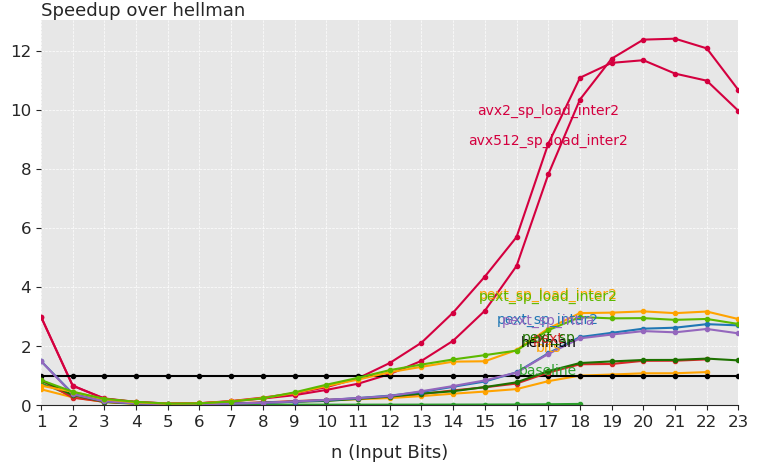

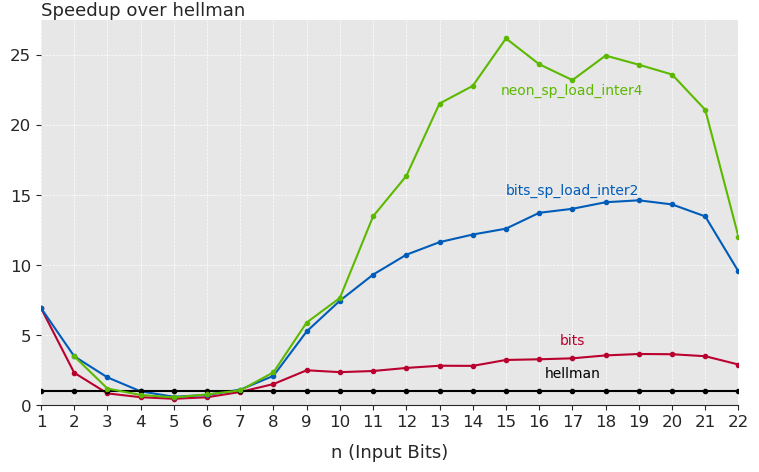

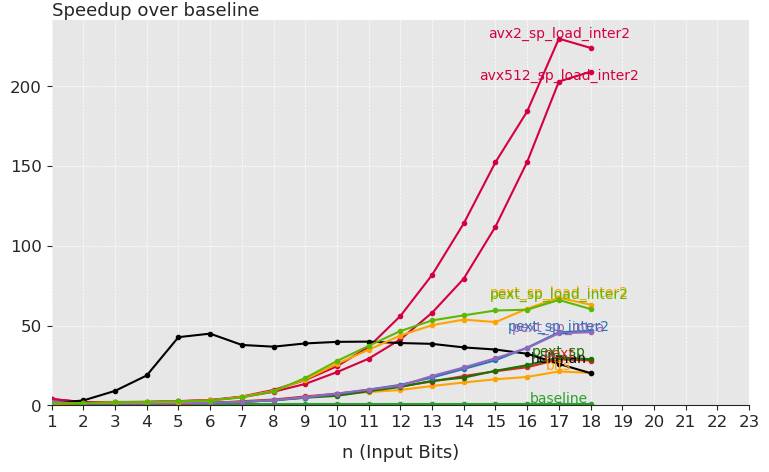

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


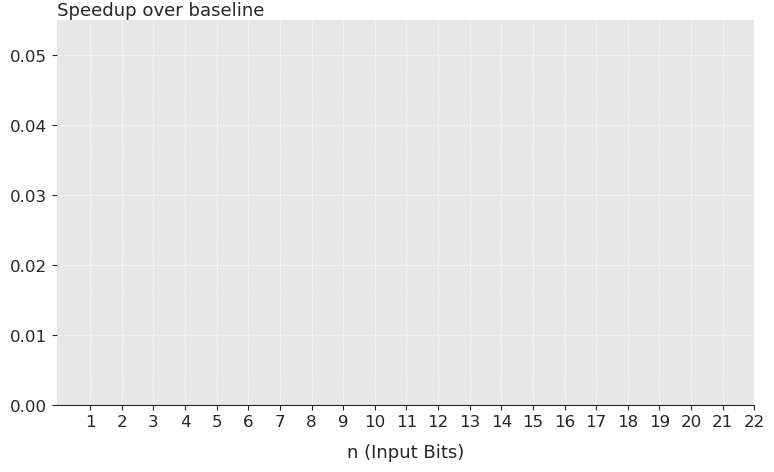

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


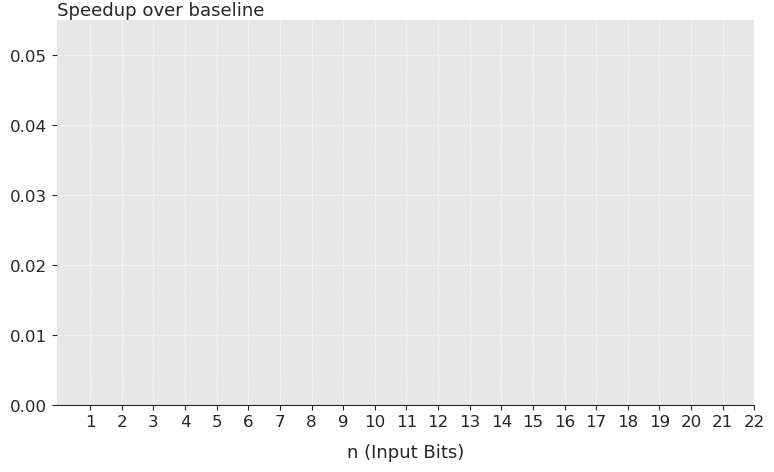

In [156]:
def speedup_plot(df: pd.DataFrame, baseline_name="hellman"):
    for (cpu_model,), df_grouped in df.groupby(
        ["cpu_model",]
    ):
        plt.figure(figsize=(9, 5))
        ax = plt.gca()
        lines: List[Tuple[str, Line2D]] = []

        # join hellman column with baseline for each bits x implementation
        baseline_cycles = df_grouped[
            df_grouped["implementation"] == baseline_name
        ].set_index("bits")["cycles"]
        df_grouped["baseline_cycles"] = df_grouped["bits"].map(baseline_cycles)
        df_grouped["speedup"] = df_grouped["baseline_cycles"] / df_grouped["cycles"]
        for (implementation, compiler_flags), group in df_grouped.groupby(
            ["implementation", "compiler_flags"]
        ):
            color = get_color_by_function_and_flags(implementation, compiler_flags)
            label = nice_function_name(implementation, compiler_flags)
            group.plot.line(
                x="bits",
                y="speedup",
                label=label,
                legend=None,
                marker="o",
                markersize=3,
                linestyle="-",
                color=color,
                ax=ax,
            )
            # Put label at bits=17, above line + 0.1
            offset_y = 1
            if "inter4" in implementation:
                offset_y = -1
            plt.text(
                17,
                group[group["bits"] == 17]["speedup"].values[0] + offset_y,
                implementation,
                color=color,
                fontsize=10,
                ha="center",
            )
            # Report max speedup
            # _i = group['speedup'].where(group['bits']== 17)
            # Get index of bits=17
            _i = group["speedup"].argmax()
            no_vec = "no-tree-vectorize" in group["compiler_flags"].values[0]
            print(
                "Max speedup at",
                group['bits'].iloc[_i],
                "of",
                implementation, 
                no_vec and "(no-vectorize)" or "",
                group.compiler_short.values[0],
                "is",
                group["speedup"].iloc[_i],
                "faster than",
                baseline_name,
            )
            # Give me speedup for bits=17
            idx = 17
            if baseline_name=="hellman":
                idx = 20
            print(
                "    Speedup at",
                17,
                "of",
                implementation,
                no_vec and "(no-vectorize)" or "",
                group.compiler_short.values[0],
                "is",
                group[group["bits"] == 17]["speedup"].values[0],
                "faster than",
                baseline_name,
            )
            line = ax.lines[-1]  # Get the last line added to the axes
            lines.append((implementation, line))

        # Keep only bottom spine
        for spine in ("left", "top", "right"):
            ax.spines[spine].set_visible(False)
        # plt.legend(
        #     loc="upper left",
        #     # bbox_to_anchor=(1, 1),
        # )
        plt.xlabel("n (Input Bits)")

        plt.ylabel(
            f"Speedup over {baseline_name}",
            rotation=0,
            verticalalignment="top",
            horizontalalignment="left",
        )
        ax.yaxis.set_label_coords(0, 1.05, transform=ax.transAxes)
        nice_title = "Performance Plot for Different Implementations"
        # plt.title(
        #     # r"$\mathbf{"
        #     # + nice_title.replace(" ", r" \ ")
        #     # + "}$"+ "\n"
        #     f"CPU: {cpu_model}\n"
        #     + f"{compiler_version} "
        #     + "\nwith "
        #     + f"{compiler_flags}",
        #     loc="left",
        #     y=1.07,
        #     # fontdict={"weight": "bold"},
        # )
        plt.grid(True)
        plt.autoscale(enable=True, axis="y", tight=False)
        plt.ylim(bottom=0)
        # plt.xlim(left=min(df_grouped["bits"]), right=max(df_grouped["bits"]))
        plt.margins(x=0)
        plt.xticks(df_grouped["bits"].unique())
        # plt.savefig("performance.png", dpi=300, bbox_inches="tight")
        Path("reportfigs").mkdir(parents=True, exist_ok=True)
        name = "_".join(df_grouped["implementation"].unique())
        for ext in [".png", ".pdf", ".ps"]:
            plt.savefig(
                f"reportfigs/speedup_{name}{ext}",
                dpi=300,
                bbox_inches="tight",
            )


df_n = df_neon[df_neon.bits <= 22]
# speedup_plot(df_n)
print(df['implementation'].unique())
# df_g2 = df[
#     df["implementation"].isin(
#         [
#             "pext_sp_load_inter2",
#             "hellman",
#             # "avx2_sp_load_inter2", ##
#             "avx2_sp_load_inter4",
#             "avx512_sp_load_intra",
#             "avx512_sp_load_inter2",
#             # "avx512_sp_load_inter4", ##
#         ]
#     )
#     & (
#         # Take everything nonvectorized, except
#         df_nonvec
#     )
# ]
speedup_plot(df, baseline_name="hellman")
speedup_plot(df, baseline_name="baseline")
print(df_n['implementation'].unique())
speedup_plot(df_n, baseline_name="baseline")


In [123]:
COLOR_MAP
COLOR_MAP[ (None, 'avx2_sp_load_inter2 (auto-vec)')] = "#d4003f"

/tmp/ipykernel_1022498/2789177547.py:306: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_roofline = df_roofline[


Wrote reportfigs/roofline_pext_sp_load_inter2.pdf


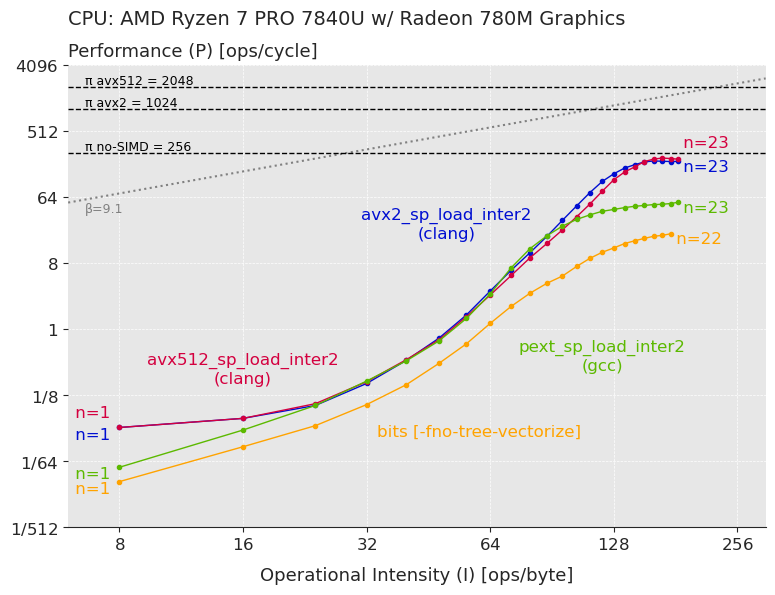

In [126]:
# ROOFLINE
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt


def roofline_plot(
    df: pd.DataFrame, title: str, annotations: Dict[str, Tuple[int, int, str]] = None
):
    for (cpu_model,), df_grouped in df.groupby(
        [
            "cpu_model",
        ]
    ):
        if "Apple" in cpu_model:
            continue
        # TODO: use hw values here
        PI_PEAK = (
            3 * 512.0
        )  # Zen 4: throughput of 3 for _mm512_and_si512 -> 3*512 logic operations per second

        # Memory bandwidth peak in B/cycle
        # Obtained by averaging 50 custom STREAM runs (array size increased to 2 mil elements)
        BETA_PEAK = 9.06  # 29899.75 MB/s / 3300 MHz = 9.06 B/cycle (for Zen 4)

        # Add your custom rooflines
        PI_PEAK_64 = 4 * 64
        PI_PEAK_256 = 4 * 256
        PI_PEAK_512 = 4 * 512

        Y_MIN, Y_MAX = 2 ** (-9), 2**12
        X_MIN, X_MAX = 6, 300
        ABOVE_LINE_TEXT_DELTA = 1.06

        # # IF you wanna see entire memory roofline, uncomment the following lines
        # Calculate X intersection of y = beta*x
        # _x_min = Y_MIN / BETA_PEAK
        # X_MIN = min(X_MIN, _x_min * 0.9)

        LOG_BASE = 2.0

        plt.figure(figsize=(9, 6))
        ax = plt.gca()
        if annotations is None:
            annotations = {}
        num_lines = 0
        num_annotated = 0
        # Plot the roofline
        # lines: List[Tuple[int, pd.Series, Line2D]] = []
        for i, (
            (
                implementation,
                compiler_flags,
                compiler,
            ),
            df_grouped,
        ) in enumerate(
            df.groupby(
                [
                    "implementation",
                    "compiler_flags",
                    "compiler_short",
                ]
            )
        ):
            color = get_color_by_function_and_flags(implementation, compiler_flags)
            if implementation == "avx2_sp_load_inter2":
                color= "#000ed1"
            df_grouped.plot.line(
                x="operational_intensity",
                y="performance",
                label=nice_function_name(implementation, compiler_flags),
                marker="o",
                legend=None,
                ax=ax,
                color=color,
                linewidth=1,
                markersize=3,
            )
            # line = ax.lines[-1]  # Get the last line added to the axes
            # lines.append((i, df_grouped.bits, line))

            all_rows = list(df_grouped.itertuples())
            if annotations is not None and implementation in annotations:
                x, y, txt = annotations[implementation]
                # y = df_grouped[df_grouped["bits"] == x]["performance"].values[0]
                # if "no-tree-vectorize" not in compiler_flags:
                #     y_delta = y_delta + 3
                ax.annotate(
                    txt.format(
                        implementation=implementation,
                        compiler_flags=compiler_flags,
                        vectorize=(
                            "[-fno-tree-vectorize]"
                            if "no-tree-vectorize" in compiler_flags
                            else ""
                        ),
                        compiler=compiler,
                    ),
                    xy=(x, y),
                    xytext=(x, y),
                    ha="center",
                    va="bottom",
                    # arrowprops=dict(arrowstyle="->", color=color),
                    # fontsize=10,
                    color=color,
                )
                num_annotated += 1
            num_lines += 1

            avx5_mul = 2 if "avx5" in implementation else 1
            first = all_rows[0]
            plt.text(
                first.operational_intensity*0.95,
                first.performance * ABOVE_LINE_TEXT_DELTA*0.95*avx5_mul,
                f" n={first.bits}",
                fontsize=12,
                verticalalignment="top",
                horizontalalignment="right",
                color=color,
                transform=ax.transData,
            )
            last = all_rows[-1]
            plt.text(
                last.operational_intensity,
                last.performance * ABOVE_LINE_TEXT_DELTA*avx5_mul,
                f" n={last.bits}",
                fontsize=12,
                verticalalignment="top",
                horizontalalignment="left",
                color=color,
                transform=ax.transData,
            )

        min_intensity = df["operational_intensity"].min()
        max_intensity = df["operational_intensity"].max()
        max_perf = df["performance"].max()

        # Extend plot range slightly for visibility
        plot_min_intensity = max(min_intensity / 4, 0.1, X_MIN)  # Start a bit above 0

        plot_max_perf = (
            max(max_perf, PI_PEAK, PI_PEAK_64, PI_PEAK_256, PI_PEAK_512) * 1.5
        )

        # Calculate roofline points
        intensity_range = np.logspace(np.log10(X_MIN), np.log10(X_MAX), 100)

        # Memory-bound roof (Performance = Beta * Intensity)
        memory_roof = BETA_PEAK * intensity_range

        # Compute-bound roof (Performance = Pi_peak)
        compute_roof = np.full_like(intensity_range, PI_PEAK)

        # Actual roofline is the minimum of the two
        roofline = np.minimum(memory_roof, compute_roof)

        # Optionally plot the components
        plt.plot(
            intensity_range,
            memory_roof,
            color="grey",
            linestyle=":",
            # label="Memory Bound",
        )
        plt.text(
            plot_min_intensity * 1.1,
            memory_roof[0],
            f"β={BETA_PEAK:.1f}",
            fontsize=9,
            color="grey",
            ha="left",
            va="top",
        )
        # plt.plot(
        #     intensity_range,
        #     compute_roof,
        #     color="grey",
        #     linestyle=":",
        #     # label="Compute Bound",
        # )
        P64_COL = "black"  # "blue"
        P256_COL = "black"  # "green"
        P512_COL = "black"  # "purple"
        plt.axhline(
            PI_PEAK_64,
            color=P64_COL,
            linestyle="--",
            linewidth=1,
            # label="π_64 = 4×64",
        )
        plt.text(
            plot_min_intensity * 1.1,
            PI_PEAK_64,
            f"π no-SIMD = {PI_PEAK_64}",
            color=P64_COL,
            va="bottom",
            fontsize=9,
        )

        plt.axhline(
            PI_PEAK_256,
            color=P256_COL,
            linestyle="--",
            linewidth=1,
            # label="π_256 = 4×256",
        )
        plt.text(
            plot_min_intensity * 1.1,
            PI_PEAK_256,
            f"π avx2 = {PI_PEAK_256}",
            color=P256_COL,
            va="bottom",
            fontsize=9,
        )

        plt.axhline(
            PI_PEAK_512,
            color=P512_COL,
            linestyle="--",
            linewidth=1,
            # label="π_512 = 4×512",
        )
        plt.text(
            plot_min_intensity * 1.1,
            PI_PEAK_512,
            f"π avx512 = {PI_PEAK_512}",
            color=P512_COL,
            va="bottom",
            fontsize=9,
        )
        # --- Formatting ---

        plt.yscale("log", base=2)
        plt.xscale("log", base=2)

        nice_title = "Roofline Measurement"
        plt.title(
            # r"$\mathbf{"
            # + nice_title.replace(" ", r" \ ")
            # + "}$\n"
            title.format(
                cpu_model=cpu_model,
            ),
            # f"CPU: {cpu_model}\n" + f"{compiler_version} ",
            # + r"$\mathit{with}$ "
            # + f"{compiler_flags}",
            loc="left",
            y=1.07,
            # fontdict={"weight": "bold"},
        )

        plt.xlabel(
            "Operational Intensity (I) [ops/byte]",
            # fontdict={"weight": "bold"},
        )
        plt.ylabel(
            "Performance (P) [ops/cycle]",
            rotation=0,
            verticalalignment="top",
            horizontalalignment="left",
        )
        ax.yaxis.set_label_coords(0, 1.05, transform=ax.transAxes)

        ax = plt.gca()
        for spine in ("left", "right", "top"):
            ax.spines[spine].set_visible(False)

        # Show symbolic fractions for ticks
        def log_ticks(x, pos):
            if x < 1:
                return r"${1}/{%d}$" % (LOG_BASE ** (-(np.log2(x))))
            return r"${%d}$" % (x)

        ax.xaxis.set_major_locator(LogLocator(base=LOG_BASE))
        ax.xaxis.set_major_formatter(plt.FuncFormatter(log_ticks))

        ax.yaxis.set_major_locator(LogLocator(base=LOG_BASE))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(log_ticks))

        ax.yaxis.set_ticks_position("left")
        if num_lines > num_annotated:
            plt.legend()
        # Background grid should be gray and lines should be white
        plt.grid(True)
        plt.xlim(X_MIN, X_MAX)
        plt.ylim(Y_MIN, Y_MAX)
        # plt.savefig("merge_roofline.png", dpi=300, bbox_inches="tight")
        # plt.show()
        name = "_".join(df_grouped["implementation"].unique())
        for ext in [".png", ".pdf"]:
            Path("reportfigs").mkdir(parents=True, exist_ok=True)
            plt.savefig(
                f"reportfigs/roofline_{name}{ext}",
                dpi=300,
                bbox_inches="tight",
            )
        print("Wrote", f"reportfigs/roofline_{name}.pdf")


# Drop everything but gcc
# We should load:
# Remove neon implementations
df_roofline = df[
~(df["compiler_version"].str.contains("Apple", na=False)|df['implementation'].str.contains("neon", na=False))
]
df_roofline = df_roofline[
    df["implementation"].isin(
        [
            # "hellman",
            # "baseline",
            "bits",
            # "pext",
            # "pext_sp",
            # "pext_sp_intra",
            # "pext_sp_load_inter2",
            # "pext_sp_load_inter2",
            "avx2_sp_load_inter2",
            "avx512_sp_load_inter2",
        ]
    )|(
        df['implementation'].str.contains("pext_sp_load_inter2", na=False) & df["compiler_flags"].str.contains("no-tree-vectorize", na=False)
    )
]
# COLOR_MAP.update({
#     (None, "bits"): "#1f77b4",
#     (None, "pext_sp_load_inter2"): "#ffa300",
#     (None, "avx2_sp_load_inter2"): "#000ed1",
#     (None, "avx512_sp_load_inter2"): "#d4003f",
# })

df_roofline.to_csv("df_roofline.csv", index=False)
roofline_plot(df_roofline, "CPU: {cpu_model}", {
    "bits": (60, 1/32, "{implementation} [-fno-tree-vectorize]"),
    # "pext": (30, 1/75, "{implementation} [-fno-tree-vectorize]"),
    # "pext_sp": (60, 1/32, "{implementation} [-fno-tree-vectorize]"),
    # "pext_sp_intra": (130, 1/8, "{implementation} [-fno-tree-vectorize]"),
    "pext_sp_load_inter2": (120, 1/4, "{implementation}\n({compiler})"),
    "avx2_sp_load_inter2": (50, 16, "{implementation}\n({compiler})"),
    "avx512_sp_load_inter2": (16, 1/6, "{implementation}\n({compiler})"),
})

['bits' 'bits_sp_load_inter2' 'hellman' 'neon_sp_load_inter4'
 'avx2_sp_load_inter2' 'avx512_sp_load_inter2' 'pext_sp_load_inter2'
 'baseline' 'pext' 'pext_sp' 'pext_sp_inter2' 'pext_sp_intra']


/tmp/ipykernel_1022498/789172765.py:131: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_g0 = df_g0[df['bits']>=5]


Wrote reportfigs/cache_hellman_pext_pext_sp.pdf
Wrote reportfigs/cache_hellman.pdf


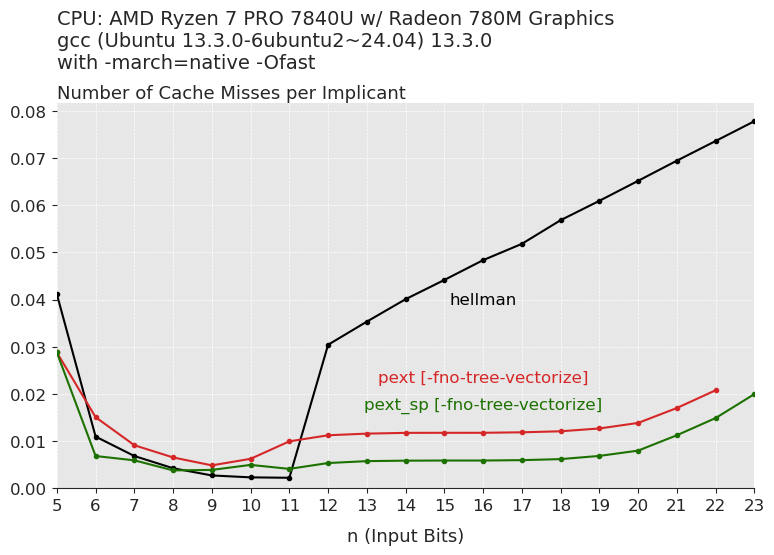

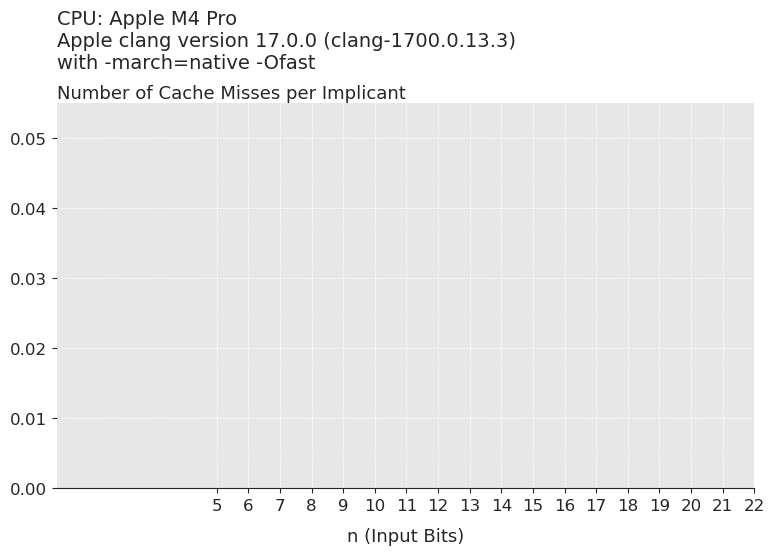

In [131]:
def cache_plot(df: pd.DataFrame,
               title: str,
               annotations: Dict[str, Tuple[int, int, str]] = None
               ):
    if annotations is None:
        annotations = {}
    for (
        cpu_model,
        compiler_version,
    ), df_grouped in df.groupby(
        [
            "cpu_model",
            "compiler_version",
        ]
    ):
        plt.figure(figsize=(9, 5))
        ax = plt.gca()
        lines: List[Tuple[str, Line2D]] = []
        for (
            implementation,
            compiler_flags,
        ), group in df_grouped.groupby(
            [
                "implementation",
                "compiler_flags",
            ]
        ):
            # color = color_map[(cpu_model, function)]
            color = get_color_by_function_and_flags(implementation, compiler_flags)
            fn_short = implementation #.split(", " + compiler_version)[0]
            # group.cache_miss_ratio = group["cache_miss_ratio"] * 100  # Convert to percentage
            group.plot.line(
                x="bits",
                y="cache_misses_per_implicant",
                label=nice_function_name(fn_short,compiler_flags),
                legend=None,
                marker="o",
                markersize=3,
                linestyle="-",
                color=color,
                ax=ax,
            )
            if implementation in annotations:
                x, y_delta, txt = annotations[implementation]
                y = group[group["bits"] == x]["cache_misses_per_implicant"].values[0]

                ax.annotate(
                    txt.format(
                        implementation=implementation, compiler_flags=compiler_flags
                    ),
                    xy=(x, y),
                    xytext=(x, y + y_delta),
                    ha="center",
                    va="bottom",
                    # arrowprops=dict(arrowstyle="->", color=color),
                    # fontsize=10,
                    color=color,
                )
            line = ax.lines[-1]  # Get the last line added to the axes
            lines.append((fn_short, line))

        # Keep only bottom spine
        for spine in ("left", "top", "right"):
            ax.spines[spine].set_visible(False)
        # plt.legend(
        #     loc="upper left",
        #     # bbox_to_anchor=(1, 1),
        # )
        plt.xlabel("n (Input Bits)")
        plt.ylabel(
            "Number of Cache Misses per Implicant",
            rotation=0,
            verticalalignment="top",
            horizontalalignment="left",
        )
        ax.yaxis.set_label_coords(0, 1.05, transform=ax.transAxes)
        plt.title(
            # r"$\mathbf{"
            # + nice_title.replace(" ", r" \ ")
            # + "}$"+ "\n"
            title.format(
                cpu_model=cpu_model,
                compiler_version=compiler_version,
            )
            # + r"$\mathit{with}$ "
            # + f"{compiler_flags}"
            ,
            loc="left",
            y=1.07,
            # fontdict={"weight": "bold"},
        )
        plt.grid(True)
        plt.autoscale(enable=True, axis="y", tight=False)
        plt.ylim(bottom=0)
        # plt.xlim(left=min(df_grouped["bits"]), right=max(df_grouped["bits"]))
        plt.margins(x=0)
        plt.xticks(df_grouped["bits"].unique())
        # plt.savefig("performance.png", dpi=300, bbox_inches="tight")
        Path("reportfigs").mkdir(parents=True, exist_ok=True)
        name = "_".join(df_grouped["implementation"].unique())
        for ext in [".png", ".pdf"]:
            plt.savefig(
                f"reportfigs/cache_{name}{ext}",
                dpi=300,
                bbox_inches="tight",
            )
        print("Wrote", f"reportfigs/cache_{name}.pdf")


print(df["implementation"].unique())
# Select 'baseline', 'bits', 'pext' 'hellman' from df for implementations
df_nonvec = df["compiler_flags"].str.contains("no-vectorize", na=False) | df[
    "compiler_flags"
].str.contains("no-tree-vectorize", na=False)
df_vec = ~df_nonvec | (df["implementation"] == "hellman")
df_nonvec = df_nonvec | (df["implementation"] == "hellman")  # Always include hellman

df_g0 = df[
    df["implementation"].isin(
        [
            "hellman",
            "pext",
            "pext_sp",
            # "pext_sp_load",
            # "pext_sp_inter2",
            # "pext_sp_load_inter2",
        ]
    )
    & df_nonvec
]
df_g0 = df_g0[df['bits']>=5]
cache_plot(df_g0,
           "CPU: {cpu_model}\n{compiler_version}\nwith -march=native -Ofast",
            annotations={
                "hellman": (16, -0.01, "{implementation}"),
                "pext": (16, +0.01, "{implementation} [-fno-tree-vectorize]"),
                "pext_sp": (16, +0.01, "{implementation} [-fno-tree-vectorize]"),
            }
           )
# performance_plot(df_g0, "Tmp performance")

{(None, 'baseline'): '#b9002e',
 (None, 'bits'): '#005cb9',
 (None, 'hellman'): '#5cb900',
 (None, 'pext'): '#b95c00',
 (None, 'pext_sp'): '#820082',
 (None, 'pext_sp_inter2'): '#00b9b9',
 (None, 'pext_sp_intra'): '#b9b900',
 (None, 'pext_sp_load_inter2 (auto-vec)'): '#b90082',
 (None, 'pext_sp_load_inter2'): '#d4003f',
 (None, 'avx2_sp_load_inter2 (auto-vec)'): '#d4003f',
 (None, 'avx512_sp_load_inter2 (auto-vec)'): '#00d435',
 (None, 'bits (auto-vec)'): '#d46f00',
 (None, 'pext (auto-vec)'): '#6f00d4',
 (None, 'pext_sp (auto-vec)'): '#00d4d4',
 (None, 'pext_sp_intra (auto-vec)'): '#d4d400',
 (None, 'baseline (auto-vec)'): '#8200b9',
 (None, 'bits_sp_load_inter2 (auto-vec)'): '#0082b9',
 (None, 'neon_sp_load_inter4 (auto-vec)'): '#00b982',
 (None, 'pext_sp_inter2 (auto-vec)'): '#5c0082',
 (None, 'avx2_sp_load_inter2'): '#82005c',
 (None, 'avx512_sp_load_inter2'): '#b9002e'}

Color avx2_sp_load_inter2, gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0, -march=native -Ofast None : #b9002e
Color avx2_sp_load_inter4, gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0, -march=native -Ofast None : #005cb9
Color avx2_sp_load_inter8, gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0, -march=native -Ofast None : #5cb900
Color avx512_sp_load_inter2, gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0, -march=native -Ofast None : #b95c00
Color avx512_sp_load_inter4, gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0, -march=native -Ofast None : #820082
Color avx512_sp_load_inter8, gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0, -march=native -Ofast None : #00b9b9
Color hellman_old, gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0, -march=native -Ofast None : #b9b900
Color pext_sp_inter2, gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0, -march=native -Ofast None : #b90082
Color pext_sp_inter4, gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0, -march=native -Ofast None : #d4003f
Color pext_sp_inter8, gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 1

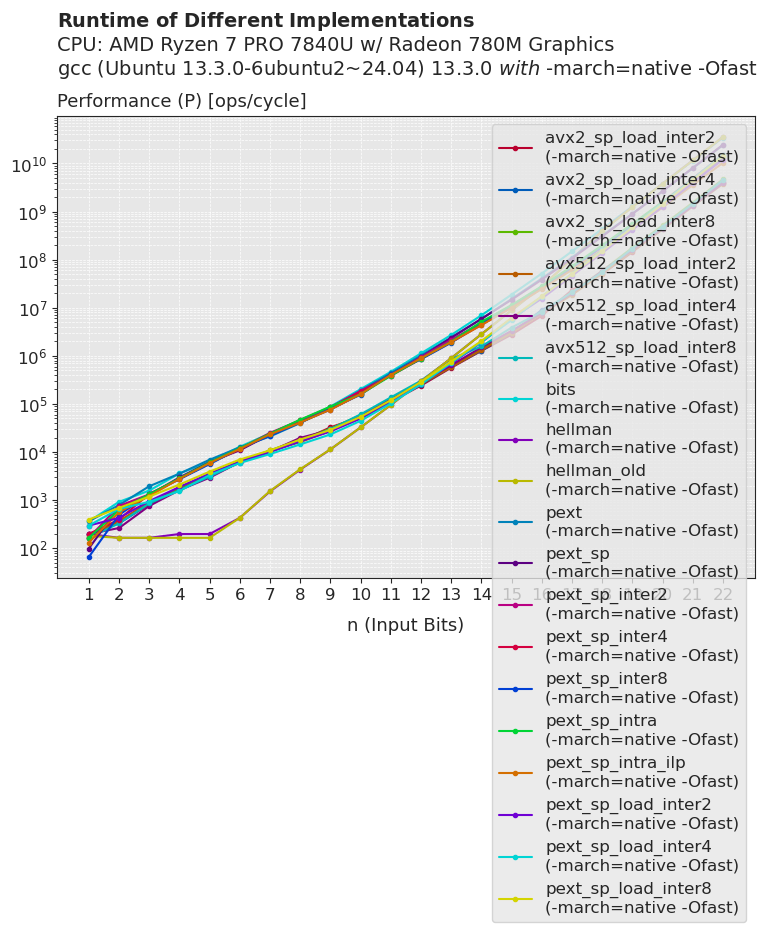

Color avx2_sp_load_inter2, gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0, -march=native -Ofast -fno-tree-vectorize None : #8200b9
Color avx2_sp_load_inter4, gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0, -march=native -Ofast -fno-tree-vectorize None : #0082b9
Color avx2_sp_load_inter8, gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0, -march=native -Ofast -fno-tree-vectorize None : #00b982
Color avx512_sp_load_inter2, gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0, -march=native -Ofast -fno-tree-vectorize None : #5c0082
Color avx512_sp_load_inter4, gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0, -march=native -Ofast -fno-tree-vectorize None : #82005c
Color avx512_sp_load_inter8, gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0, -march=native -Ofast -fno-tree-vectorize None : #b9002e
Color pext_sp_inter2, gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0, -march=native -Ofast -fno-tree-vectorize None : #005cb9
Color pext_sp_intra, gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0, -march=native -Ofast -fno-tree-vectorize None : #5cb9

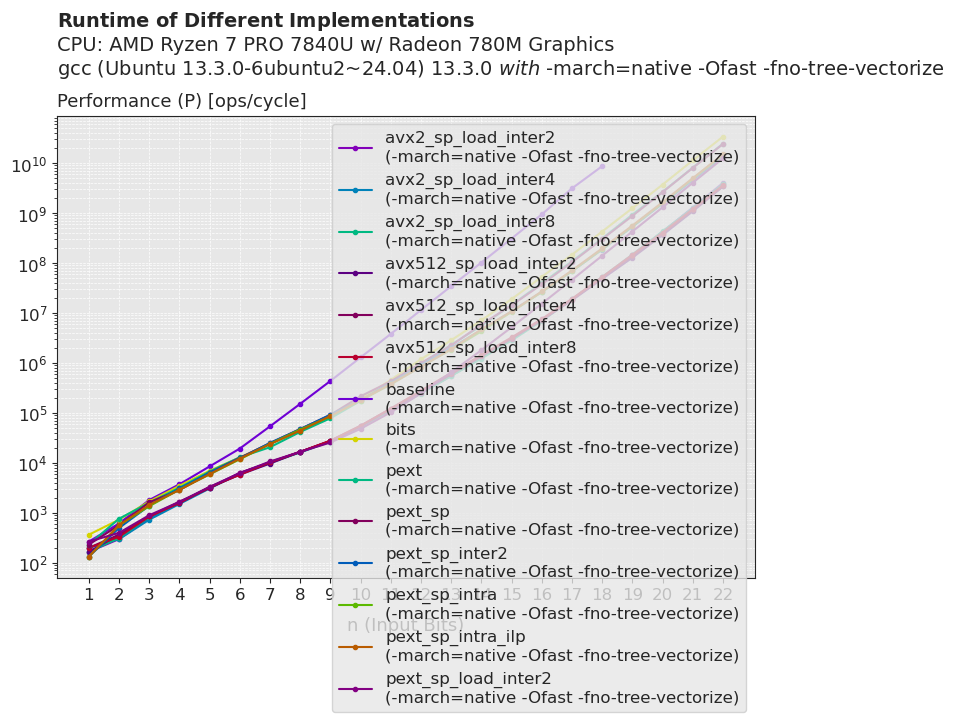

In [ ]:
def runtime_plot(df:pd.DataFrame):
    """
    Generates a log-runtime plot for different implementations.
    Creates a separate plot for each CPU model found in the DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame containing 'bits', 'cycles',
                           'function', and 'cpu_model' columns.
    """
    # Group by CPU model to create a separate plot for each
    for (cpu_model, compiler_version, compiler_flags), df_grouped in df.groupby(
        ["cpu_model", "compiler_version", "compiler_flags"]
    ):
        # Create the plot
        plt.figure(figsize=(9, 6))
        ax = plt.gca()
        for function, group in df_grouped.groupby("function"):
            color = get_color_by_function_and_flags(function, cpu_model)
            fn_short = function.split(", " + compiler_version)[0]
            group.plot.line(
                x="bits",
                y="cycles",
                label=nice_function_name(fn_short,compiler_flags),
                legend=None,
                marker="o",
                markersize=3,
                linestyle="-",
                color=color,
                ax=ax,
            )

        # --- Formatting ---
        # Set y-axis to a logarithmic scale, which is crucial for runtime plots
        plt.yscale("log")

        # Labels and Title
        plt.xlabel("n (Input Bits)")

        plt.ylabel("Runtime [cycles] (log scale)")
        plt.title(
            f"Runtime of all implementations for different number of bits n\nCPU: {cpu_model}",
            loc="left",
        )

        plt.ylabel(
            "Performance (P) [ops/cycle]",
            rotation=0,
            verticalalignment="top",
            horizontalalignment="left",
        )
        ax.yaxis.set_label_coords(0, 1.05, transform=ax.transAxes)
        
        nice_title = "Runtime of Different Implementations"
        plt.title(
            r"$\mathbf{"
            + nice_title.replace(" ", r" \ ")
            + "}$"
            + f"\nCPU: {cpu_model}\n"
            + f"{compiler_version} "
            + r"$\mathit{with}$ "
            + f"{compiler_flags}",
            loc="left",
            y=1.07,
            # fontdict={"weight": "bold"},
        )

        # Grid and Ticks for better readability
        plt.grid(True, which="both")
        plt.xticks(df_grouped["bits"].unique())

        # Save and show the plot
        # Create a unique filename for each CPU to avoid overwriting
        safe_cpu_model_name = cpu_model.replace(" ", "_").replace("@", "")
        plt.legend()
        plt.show()


runtime_plot(df)